# Image classification

In [7]:
import torch
from torch import Generator

# Set the random seed for reproducibility
random_state = 42

In [8]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Preprocessing

In [9]:
import os
from data import train_val_split

base_dir = './data/train'
train_dir = './data/preprocessed/train'
val_dir = './data/preprocessed/val'

val_ratio = 0.2

if not os.path.exists(train_dir) and not os.path.exists(val_dir):
    train_val_split(base_dir, train_dir, val_dir, val_ratio, random_state) 

    print("Saved train data to:", train_dir)
    print("Saved validation data to:", val_dir)
else:
    print("Train and validation directories already exist.")

Train and validation directories already exist.


## Data

In [10]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
from data import sample_dataset

default_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augmented_transform = transforms.Compose([
    transforms.RandomCrop(64, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_default_ds = ImageFolder(train_dir, transform=default_transform)
train_augmented_ds = ImageFolder(train_dir, transform=augmented_transform)
train_ds = ConcatDataset([train_default_ds, train_augmented_ds])

val_ds = ImageFolder(val_dir, transform=default_transform)

# downsample the dataset
sample_ratio = 0.5
sampled_train_ds = sample_dataset(train_ds, sample_ratio, seed=random_state)
sampled_val_ds = sample_dataset(val_ds, sample_ratio, seed=random_state)

num_classes = len(train_default_ds.classes)

print(f"Number of training samples: {len(sampled_train_ds)}")
print(f"Number of validation samples: {len(sampled_val_ds)}")

batch_size = 128
num_workers = 0

# setup data loaders
train_dl = DataLoader(sampled_train_ds,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=True,
                      generator=Generator().manual_seed(random_state))

val_dl = DataLoader(sampled_val_ds,
                    batch_size=batch_size,
                    num_workers=num_workers, 
                    shuffle=False)

Number of training samples: 70409
Number of validation samples: 8801


Sample image shape: torch.Size([3, 64, 64])
Sample label: 0


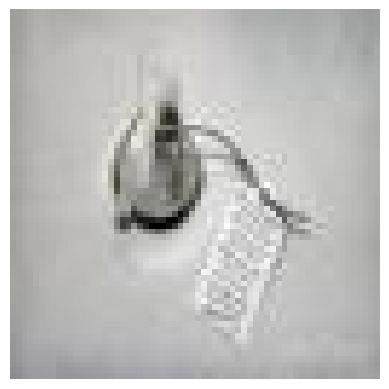

In [11]:
from utils import show_image

sample_img, sample_label = train_ds[0]

print(f"Sample image shape: {sample_img.size()}")
print(f"Sample label: {sample_label}")

show_image(sample_img)

## Training

In [12]:
from training import Trainer
import torch.optim as optim

### BasicModel

In [17]:
from models import BasicNet

basicNet = BasicNet(num_classes=num_classes)

optimizer = optim.Adam(basicNet.to(device).parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(basicNet, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=10)

Epoch 1/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  8.95it/s]


Epoch 1/10: Train Loss: 3.2696, Val Loss: 2.7665, Avg Class Accuracy: 0.2707


Epoch 2/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  8.91it/s]


Epoch 2/10: Train Loss: 2.7737, Val Loss: 2.4604, Avg Class Accuracy: 0.3353


Epoch 3/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  8.86it/s]


Epoch 3/10: Train Loss: 2.5412, Val Loss: 2.2696, Avg Class Accuracy: 0.3827


Epoch 4/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  8.87it/s]


Epoch 4/10: Train Loss: 2.3905, Val Loss: 2.1767, Avg Class Accuracy: 0.4029


Epoch 5/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  8.92it/s]


Epoch 5/10: Train Loss: 2.2854, Val Loss: 2.1152, Avg Class Accuracy: 0.4140


Epoch 6/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  8.85it/s]


Epoch 6/10: Train Loss: 2.2003, Val Loss: 2.0349, Avg Class Accuracy: 0.4384


Epoch 7/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  8.82it/s]


Epoch 7/10: Train Loss: 2.1270, Val Loss: 1.9695, Avg Class Accuracy: 0.4526


Epoch 8/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  8.89it/s]


Epoch 8/10: Train Loss: 2.0670, Val Loss: 1.9643, Avg Class Accuracy: 0.4529


Epoch 9/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  8.77it/s]


Epoch 9/10: Train Loss: 2.0232, Val Loss: 1.9026, Avg Class Accuracy: 0.4757


Epoch 10/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  8.76it/s]

Epoch 10/10: Train Loss: 1.9739, Val Loss: 1.8580, Avg Class Accuracy: 0.4804


### Renset-like model

In [14]:
# from models import SimpleResNet

# simpleResNet = SimpleResNet(num_classes=num_classes)

# optimizer = optim.Adam(simpleResNet.to(device).parameters(), lr=1e-3, weight_decay=1e-5)

# trainer = Trainer(simpleResNet, train_dl, val_dl, optimizer, device=device)
# trainer.train(num_epochs=10)

### Four-block CNN

In [ ]:
from models import FourBlockCNN

fourBlockCNN = FourBlockCNN(num_classes=50)

optimizer = optim.Adam(fourBlockCNN.to(device).parameters(), lr=1e-3, weight_decay=1e-5)

trainer = Trainer(fourBlockCNN, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=10)

# Results:
# Without augmentation: Epoch 10/10: Train Loss: 2.2281, Val Loss: 2.4054, Avg Class Accuracy: 0.3387
# With augmentation: Epoch 10/10: Train Loss: 1.7477, Val Loss: 1.8611, Avg Class Accuracy: 0.4847

Epoch 1/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  7.93it/s]


Epoch 1/10: Train Loss: 3.2531, Val Loss: 3.1608, Avg Class Accuracy: 0.1574


Epoch 2/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  7.87it/s]


Epoch 2/10: Train Loss: 2.8960, Val Loss: 2.8528, Avg Class Accuracy: 0.2164


Epoch 3/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  7.81it/s]


Epoch 3/10: Train Loss: 2.6463, Val Loss: 2.6242, Avg Class Accuracy: 0.2767


Epoch 4/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  7.73it/s]


Epoch 4/10: Train Loss: 2.4411, Val Loss: 2.4591, Avg Class Accuracy: 0.3124


Epoch 5/10 (validation): 100%|██████████| 69/69 [00:09<00:00,  7.49it/s]


Epoch 5/10: Train Loss: 2.2763, Val Loss: 2.2984, Avg Class Accuracy: 0.3614


Epoch 6/10 (validation): 100%|██████████| 69/69 [00:09<00:00,  7.63it/s]


Epoch 6/10: Train Loss: 2.1424, Val Loss: 2.1042, Avg Class Accuracy: 0.4088


Epoch 7/10 (validation): 100%|██████████| 69/69 [00:09<00:00,  7.60it/s]


Epoch 7/10: Train Loss: 2.0279, Val Loss: 2.0566, Avg Class Accuracy: 0.4231


Epoch 8/10 (validation): 100%|██████████| 69/69 [00:09<00:00,  7.65it/s]


Epoch 8/10: Train Loss: 1.9191, Val Loss: 2.1329, Avg Class Accuracy: 0.4211


Epoch 9/10 (validation): 100%|██████████| 69/69 [00:09<00:00,  7.60it/s]


Epoch 9/10: Train Loss: 1.8304, Val Loss: 1.9594, Avg Class Accuracy: 0.4600


Epoch 10/10 (validation): 100%|██████████| 69/69 [00:09<00:00,  7.50it/s]

Epoch 10/10: Train Loss: 1.7477, Val Loss: 1.8611, Avg Class Accuracy: 0.4847


## Resnet18

Here we train the ResNet18 model on the dataset to see the state of the art performance.

In [16]:
import torch.nn as nn

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features, num_classes)

resnet18 = resnet18.to(device)

optimizer = optim.Adam(resnet18.parameters(), lr=1e-4, weight_decay=1e-5)

trainer = Trainer(resnet18, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=10)

Using cache found in /Users/grzegorzstatkiewicz/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/grzegorzstatkiewicz/Documents/studies/ssne/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/grzegorzstatkiewicz/Documents/studies/ssne/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 1/10 (validation): 100%|██████████| 69/69 [00:07<00:00,  9.11it/s]


Epoch 1/10: Train Loss: 2.9296, Val Loss: 2.5798, Avg Class Accuracy: 0.3070


Epoch 2/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  8.07it/s]


Epoch 2/10: Train Loss: 2.3317, Val Loss: 2.3422, Avg Class Accuracy: 0.3667


Epoch 3/10 (validation): 100%|██████████| 69/69 [00:09<00:00,  7.48it/s]


Epoch 3/10: Train Loss: 2.0132, Val Loss: 2.2255, Avg Class Accuracy: 0.4022


Epoch 4/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  7.77it/s]


Epoch 4/10: Train Loss: 1.7531, Val Loss: 2.1050, Avg Class Accuracy: 0.4324


Epoch 5/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  7.74it/s]


Epoch 5/10: Train Loss: 1.5111, Val Loss: 2.0847, Avg Class Accuracy: 0.4436


Epoch 6/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  7.78it/s]


Epoch 6/10: Train Loss: 1.2983, Val Loss: 2.1678, Avg Class Accuracy: 0.4384


Epoch 7/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  8.03it/s]


Epoch 7/10: Train Loss: 1.1273, Val Loss: 2.1908, Avg Class Accuracy: 0.4495


Epoch 8/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  8.20it/s]


Epoch 8/10: Train Loss: 0.9858, Val Loss: 2.2460, Avg Class Accuracy: 0.4447


Epoch 9/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  7.82it/s]


Epoch 9/10: Train Loss: 0.8803, Val Loss: 2.2935, Avg Class Accuracy: 0.4512


Epoch 10/10 (validation): 100%|██████████| 69/69 [00:08<00:00,  7.88it/s]

Epoch 10/10: Train Loss: 0.8006, Val Loss: 2.3406, Avg Class Accuracy: 0.4562
